In [1]:
#reading the data
import matplotlib.pyplot as plt
import pandas as pd

btc_blockchain_data = pd.read_csv("cryptoCompareData/btc_blockchain_data.csv", thousands=',')
btc_prices= pd.read_csv("cryptoCompareData/btc_prices.csv", thousands=',')
btc_social = pd.read_csv("cryptoCompareData/btc_social.csv", thousands=',')

In [2]:
btc_info = btc_prices\
    .merge(btc_blockchain_data, on='time', how='outer')\
    .sort_values('time')\
    .dropna(subset=['close'])
btc_info['time'] = pd.to_datetime(btc_info['time'])
btc_info.set_index(btc_info['time']);

#### trying to find important features for classification (price will go up or down) for the next day

In [3]:
btc_info['closing_price_increased'] = btc_info['close'] > btc_info['close'].shift(-1)
btc_info[['closing_price_increased','close','time']].head(5)

,closing_price_increased,close,time
0,False,0.04951,2010-07-17
1,True,0.08584,2010-07-18
2,True,0.08080,2010-07-19
3,False,0.07474,2010-07-20
4,True,0.07921,2010-07-21


## PCA for social media

In [4]:
btc_social.iloc[110:].head(10)

,comments,posts,followers,fb_likes,fb_talking_about,twitter_followers,twitter_following,twitter_lists,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,time
110,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,2017-05-20
111,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,2017-05-21
112,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,2017-05-22
113,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,2017-05-23
114,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,2017-05-24
115,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,2017-05-25
116,5634,2370,5851,31479,597,194066,105,2783,76,18775,230517,4748,23.10,554.38,351.56,8437.50,2017-05-26
117,5827,2427,5990,31505,565,195011,105,2787,76,18781,231470,15977,13.78,330.62,172.08,4130.02,2017-05-27
118,5873,2443,6090,31539,533,195817,105,2795,76,18787,232185,3070,14.01,336.20,138.09,3314.15,2017-05-28
119,5896,2458,6199,31560,453,196623,105,2795,76,18793,232777,3448,15.27,366.41,267.86,6428.57,2017-05-29


#### only reddit data is diverse enough to have at least a little trust. others contain probably filled-in,constant values in most places

In [5]:
from sklearn.decomposition import PCA
pca_social = btc_social.filter(regex='reddit').iloc[116:].drop(columns='time',errors='ignore')
print('columns originally:', len(pca_social.columns))
preserved_variance=0.95
pca = PCA(n_components=preserved_variance)
pca.fit((pca_social-pca_social.mean())/pca_social.std())
print('gained PC variance ratios:',pca.explained_variance_ratio_, 'with sum ',sum(pca.explained_variance_ratio_))

columns originally: 6
gained PC variance ratios: [0.62574215 0.21356001 0.10094112 0.05975669] with sum  0.999999972707009


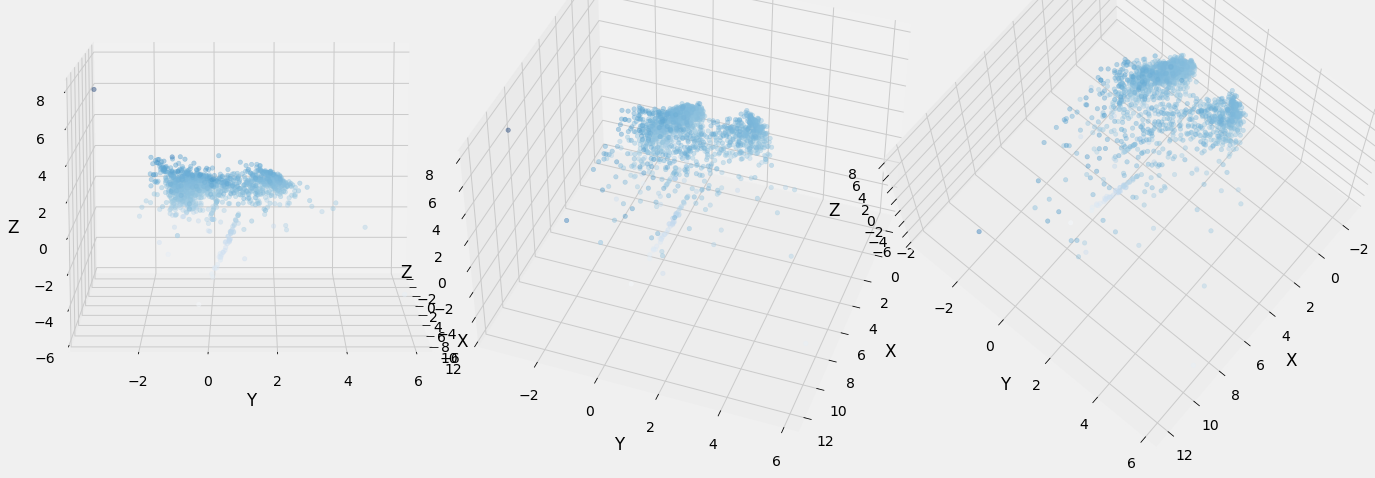

In [6]:
import  seaborn as sns
transformed_pca_social = pca.transform((pca_social-pca_social.mean())/pca_social.std())

plt.style.use("fivethirtyeight")
fig, axes = plt.subplots(1,3,figsize=(20,10),subplot_kw=dict(projection='3d'))
for idx,ax in enumerate(axes):
    ax.view_init(elev=10+idx*30, azim=idx*20)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.dist=7
    ax.scatter3D(transformed_pca_social[:,0], transformed_pca_social[:,1], transformed_pca_social[:,2], c=transformed_pca_social[:,2], cmap='Blues',alpha=0.4)


<AxesSubplot:>

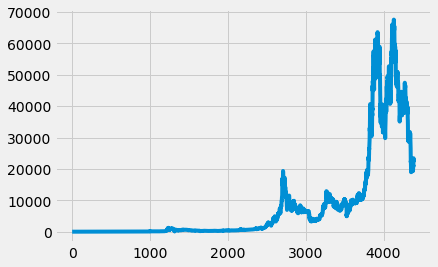

In [8]:
btc_info['close'].plot()

<AxesSubplot:>

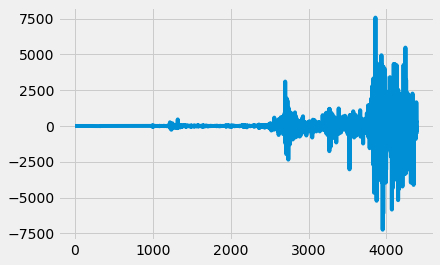

In [16]:
btc_info['close'].diff().plot()

<AxesSubplot:>

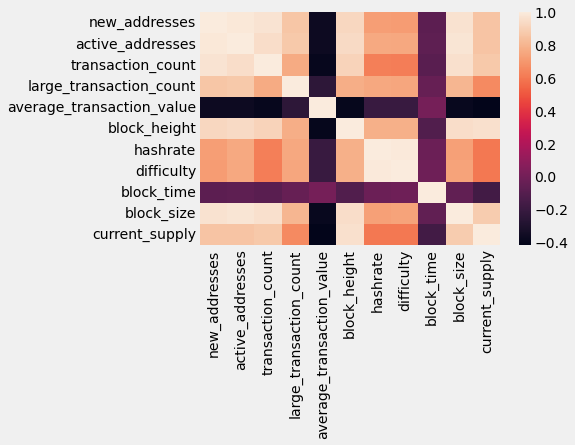

In [17]:
import seaborn as sns

all_time = btc_blockchain_data.filter(regex='all_time')
corr = btc_blockchain_data.drop(columns=all_time.columns).corr()
sns.heatmap(corr,
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [26]:
print(corr['new_addresses'].sort_values(ascending=False)) #Keep active addresses instead
print(btc_info['new_addresses'].corr(btc_info['close']))
print(btc_info['active_addresses'].corr(btc_info['close']))

new_addresses                1.000000
active_addresses             0.987892
transaction_count            0.967000
block_size                   0.966468
block_height                 0.925167
large_transaction_count      0.856524
current_supply               0.853905
hashrate                     0.719778
difficulty                   0.715403
block_time                  -0.077595
average_transaction_value   -0.375415
Name: new_addresses, dtype: float64
0.625032336690654
0.6774152235005213


In [31]:
print(corr['hashrate'].sort_values(ascending=False)) #lets keep hashrate
print("difficulty corr:",btc_info['difficulty'].corr(btc_info['close'])) #lets keep difficulty, because that has higher correlations
print("hashrate corr:",btc_info['hashrate'].corr(btc_info['close'])) #lets keep difficulty, because that has higher correlations

hashrate                     1.000000
difficulty                   0.991673
block_height                 0.779334
active_addresses             0.759308
large_transaction_count      0.751558
block_size                   0.725023
new_addresses                0.719778
transaction_count            0.618991
current_supply               0.596259
block_time                  -0.031011
average_transaction_value   -0.206705
Name: hashrate, dtype: float64
difficulty corr: 0.8416045091194333
hashrate corr: 0.8431483453331242


<AxesSubplot:>

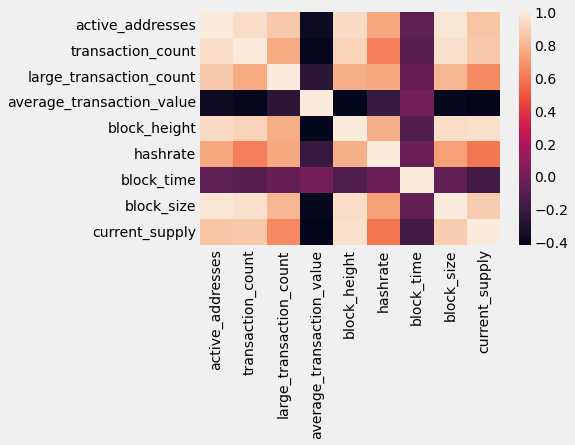

In [42]:
all_time = btc_blockchain_data.filter(regex='all_time')
filtered_corr = btc_blockchain_data.drop(columns=all_time.columns.tolist() + ['new_addresses','difficulty']).corr()
sns.heatmap(corr,
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [46]:
pca = PCA(n_components=0.99)
pca.fit((filtered_corr-filtered_corr.mean())/filtered_corr.std())
print('gained PC variance ratios:',pca.explained_variance_ratio_, 'with sum ',sum(pca.explained_variance_ratio_))

gained PC variance ratios: [0.88201152 0.08879801 0.02157467] with sum  0.9923841954211502
